## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [1]:
cd ../dataprocessing

/usr/local/google/home/carverforbes/activity-recognition/location/lbs/activity/audioset/dataprocessing


## Call the import statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [2]:
# import statements
import audio_processing as ap

import functools
import os
import sys
from absl import logging

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Ran the import statements.


In [3]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [4]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'gunshot_50_50'
notebook = 'training_rms_cnn'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate'
]
features_to_extract = ['rms']

In [ ]:
# Import the dataset
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, False)

In [6]:
df.head()

,label,rms
0,1,"[[0.02405279, 0.023330143, 0.023758966, 0.0242..."
1,1,"[[0.018282387, 0.018027905, 0.017703341, 0.016..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,"[[0.04338157, 0.04964902, 0.05274851, 0.055846..."
4,0,"[[0.006664924, 0.0066831713, 0.0066637434, 0.0..."


In [7]:
def fix_dataframe(dataframe):
    # temp bug fix for rows with None features
    # and rows with different number of elements per frame
    bad_rows = []
    for i in dataframe.index:
        if dataframe.rms[i] is None:
            bad_rows.append(i)
        elif dataframe.rms[i][0] is None:
            bad_rows.append(i)
        elif len(dataframe.rms[i][0]) != 431:
            bad_rows.append(i)
    new_dataframe = dataframe.drop(bad_rows)
    return new_dataframe

In [8]:
def shuffle_dataframe(dataframe):
    # Shuffle the dataset/dataframe.
    dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
    return dataframe

In [9]:
def dataframe_to_x_y(dataframe):
    X = np.array(dataframe.rms.tolist(), dtype=object)
    y = np.array(dataframe.label.tolist())
    
    # Convert arrays of objects to arrays of floats.
    X = tf.keras.backend.cast_to_floatx(X)
    y = tf.keras.backend.cast_to_floatx(y)
    return X, y

In [10]:
def data_preprocessing(dataframe):
    print('Dropping incongruent features from dataframe')
    dataframe = fix_dataframe(dataframe)
    print('shuffling dataframe')
    dataframe = shuffle_dataframe(dataframe)
    print('Getting X, y out of dataframe')
    X, y = dataframe_to_x_y(dataframe)
    x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state = 42)
    return x_train, y_train, x_val, y_val

In [11]:
x_train, y_train, x_val, y_val = data_preprocessing(df)

Dropping incongruent features from dataframe
shuffling dataframe
Getting X, y out of dataframe


In [32]:
x_train = x_train.reshape(y_train.shape[0], 431, 1)
x_val = x_val.reshape(y_val.shape[0], 431, 1)

In [33]:
def make_dir(path):
    if not os.path.isdir(path):
        try:
            os.mkdir(path)
        except OSError as error:
            logging.error(error)
            return False
    return True

In [34]:
# Define the plotting function.
def plot_curve(epochs, hist, dest_path, notebook_filename, dataset_filename, list_of_metrics, list_of_hyperparameters):
    """Plot a curve of one or more classification metrics vs. epoch and save it to path."""  
    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    
    make_dir(dest_path)    
    path = os.path.join(dest_path, notebook_filename)
    make_dir(path)
    path = os.path.join(path, dataset_filename)
    make_dir(path)
        
    list_of_hyperparameters_temp = [str(item) for item in list_of_hyperparameters]
    filename = '_'.join(list_of_hyperparameters_temp)
    path = os.path.join(path, filename + '.png')
    plt.savefig(path, bbox_inches='tight')
    
    return plt


print("Defined the plot_curve function.")

Defined the plot_curve function.


## Training 1

In [35]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.   
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 10)           440       
_________________________________________________________________
Flatten_1 (Flatten)          (None, 3890)              0         
_________________________________________________________________
Hidden1 (Dense)              (None, 20)                77820     
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 78,281
Trainable params: 78,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
351/351 [==============================] - 6s 18ms/step - loss: 0.6719 - accuracy: 0.5556 - precision: 0.7195 - recall: 0.0778 - val_loss: 0.6625 - val_accuracy: 0.5586 - val_precision: 0.7344 - val_recall: 0.0471
Epoch 2/50
351/351 [===

351/351 [==============================] - 5s 15ms/step - loss: 0.6180 - accuracy: 0.5726 - precision: 0.7426 - recall: 0.1284 - val_loss: 0.6248 - val_accuracy: 0.5824 - val_precision: 0.6934 - val_recall: 0.1474
Epoch 34/50
351/351 [==============================] - 5s 15ms/step - loss: 0.6184 - accuracy: 0.5758 - precision: 0.7503 - recall: 0.1360 - val_loss: 0.6319 - val_accuracy: 0.5691 - val_precision: 0.6688 - val_recall: 0.1053
Epoch 35/50
351/351 [==============================] - 5s 15ms/step - loss: 0.6179 - accuracy: 0.5772 - precision: 0.7458 - recall: 0.1421 - val_loss: 0.6249 - val_accuracy: 0.5764 - val_precision: 0.6806 - val_recall: 0.1304
Epoch 36/50
351/351 [==============================] - 5s 15ms/step - loss: 0.6179 - accuracy: 0.5737 - precision: 0.7462 - recall: 0.1309 - val_loss: 0.6220 - val_accuracy: 0.5769 - val_precision: 0.7059 - val_recall: 0.1204
Epoch 37/50
351/351 [==============================] - 5s 15ms/step - loss: 0.6191 - accuracy: 0.5753 - prec

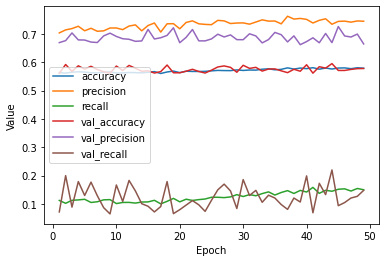

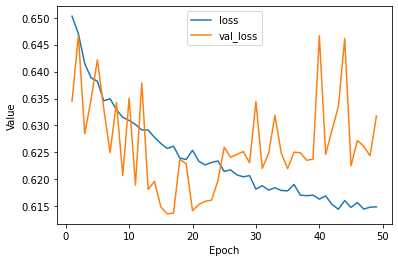

In [36]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 50
batch_size = 25
classification_threshold = 0.70
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# Metrics to measure model performance
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Create model
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 2

In [37]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.MaxPooling1D(pool_size=20,
                                           strides=19,
                                           padding='valid',
                                           name='MaxPooling1D_1'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L1 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=100, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.   
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 5)            220       
_________________________________________________________________
MaxPooling1D_1 (MaxPooling1D (None, 20, 5)             0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
Hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Output (Dense)               (None, 1)                 101       
Total params: 10,421
Trainable params: 10,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
351/351 [==============================] - 6s 16ms/step - loss: 0.7000 - accuracy: 0.5361 - precision: 0

Epoch 33/100
351/351 [==============================] - 5s 14ms/step - loss: 0.6149 - accuracy: 0.5939 - precision: 0.7661 - recall: 0.1866 - val_loss: 0.6211 - val_accuracy: 0.6011 - val_precision: 0.7338 - val_recall: 0.1936
Epoch 34/100
351/351 [==============================] - 5s 15ms/step - loss: 0.6143 - accuracy: 0.5963 - precision: 0.7831 - recall: 0.1864 - val_loss: 0.6185 - val_accuracy: 0.5806 - val_precision: 0.7407 - val_recall: 0.1204
Epoch 35/100
351/351 [==============================] - 5s 14ms/step - loss: 0.6131 - accuracy: 0.5952 - precision: 0.7832 - recall: 0.1830 - val_loss: 0.6236 - val_accuracy: 0.6102 - val_precision: 0.7214 - val_recall: 0.2337
Epoch 36/100
351/351 [==============================] - 5s 14ms/step - loss: 0.6140 - accuracy: 0.5975 - precision: 0.7836 - recall: 0.1896 - val_loss: 0.6286 - val_accuracy: 0.6148 - val_precision: 0.7270 - val_recall: 0.2457
Epoch 37/100
351/351 [==============================] - 5s 15ms/step - loss: 0.6134 - accura

351/351 [==============================] - 8s 23ms/step - loss: 0.5980 - accuracy: 0.6278 - precision: 0.8243 - recall: 0.2571 - val_loss: 0.6432 - val_accuracy: 0.6257 - val_precision: 0.7185 - val_recall: 0.2919
Epoch 70/100
351/351 [==============================] - 8s 22ms/step - loss: 0.5964 - accuracy: 0.6295 - precision: 0.8224 - recall: 0.2627 - val_loss: 0.6441 - val_accuracy: 0.6038 - val_precision: 0.7329 - val_recall: 0.2036
Epoch 71/100
351/351 [==============================] - 8s 22ms/step - loss: 0.5978 - accuracy: 0.6316 - precision: 0.8277 - recall: 0.2657 - val_loss: 0.6463 - val_accuracy: 0.6239 - val_precision: 0.7201 - val_recall: 0.2839
Epoch 72/100
351/351 [==============================] - 8s 23ms/step - loss: 0.5963 - accuracy: 0.6324 - precision: 0.8233 - recall: 0.2701 - val_loss: 0.6497 - val_accuracy: 0.6139 - val_precision: 0.7103 - val_recall: 0.2558
Epoch 73/100
351/351 [==============================] - 5s 15ms/step - loss: 0.5953 - accuracy: 0.6312 - 

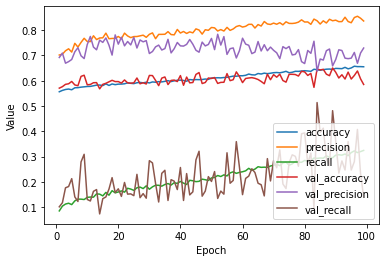

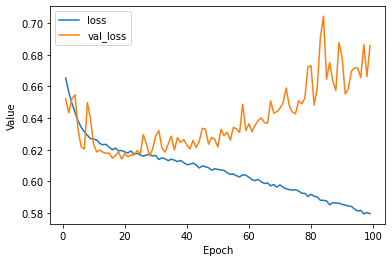

In [38]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
label_name = "label"


# Metrics to measure model performance
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Create model
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

## Training 3

In [39]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.MaxPooling1D(pool_size=20,
                                           strides=19,
                                           padding='valid',
                                           name='MaxPooling1D_1'))
    
    model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=2, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_2'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L1 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=100, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)
    epochs = history.epoch
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 10)           440       
_________________________________________________________________
MaxPooling1D_1 (MaxPooling1D (None, 20, 10)            0         
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 19, 1)             21        
_________________________________________________________________
Flatten_1 (Flatten)          (None, 19)                0         
_________________________________________________________________
Hidden1 (Dense)              (None, 100)               2000      
_________________________________________________________________
Output (Dense)               (None, 1)                 101       
Total params: 2,562
Trainable params: 2,562
Non-trainable params: 0
____________________________________________________

351/351 [==============================] - 5s 15ms/step - loss: 0.6198 - accuracy: 0.6417 - precision: 0.7135 - recall: 0.3880 - val_loss: 0.6090 - val_accuracy: 0.6463 - val_precision: 0.7118 - val_recall: 0.3741
Epoch 33/100
351/351 [==============================] - 5s 15ms/step - loss: 0.6188 - accuracy: 0.6378 - precision: 0.7136 - recall: 0.3735 - val_loss: 0.6097 - val_accuracy: 0.6417 - val_precision: 0.6985 - val_recall: 0.3741
Epoch 34/100
351/351 [==============================] - 6s 16ms/step - loss: 0.6186 - accuracy: 0.6414 - precision: 0.7184 - recall: 0.3806 - val_loss: 0.6122 - val_accuracy: 0.6559 - val_precision: 0.6926 - val_recall: 0.4383
Epoch 35/100
351/351 [==============================] - 6s 16ms/step - loss: 0.6178 - accuracy: 0.6468 - precision: 0.7202 - recall: 0.3973 - val_loss: 0.6139 - val_accuracy: 0.6563 - val_precision: 0.7075 - val_recall: 0.4173
Epoch 36/100
351/351 [==============================] - 6s 16ms/step - loss: 0.6165 - accuracy: 0.6421 - 

351/351 [==============================] - 6s 16ms/step - loss: 0.6082 - accuracy: 0.6594 - precision: 0.7379 - recall: 0.4188 - val_loss: 0.6093 - val_accuracy: 0.6728 - val_precision: 0.7096 - val_recall: 0.4754
Epoch 69/100
351/351 [==============================] - 5s 15ms/step - loss: 0.6073 - accuracy: 0.6649 - precision: 0.7459 - recall: 0.4273 - val_loss: 0.6065 - val_accuracy: 0.6645 - val_precision: 0.7213 - val_recall: 0.4283
Epoch 70/100
351/351 [==============================] - 5s 15ms/step - loss: 0.6074 - accuracy: 0.6573 - precision: 0.7296 - recall: 0.4217 - val_loss: 0.6250 - val_accuracy: 0.6901 - val_precision: 0.6939 - val_recall: 0.5707
Epoch 71/100
351/351 [==============================] - 5s 15ms/step - loss: 0.6081 - accuracy: 0.6602 - precision: 0.7363 - recall: 0.4234 - val_loss: 0.6080 - val_accuracy: 0.6586 - val_precision: 0.7456 - val_recall: 0.3791
Epoch 72/100
351/351 [==============================] - 5s 15ms/step - loss: 0.6091 - accuracy: 0.6577 - 

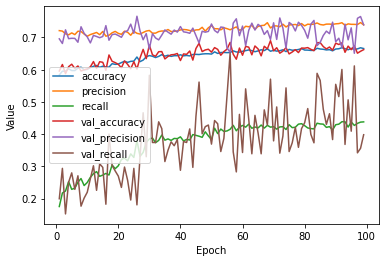

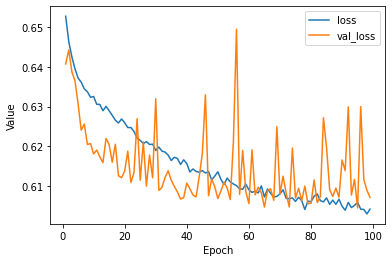

In [40]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.65
label_name = "label"

list_of_hyperparameters = [learning_rate, epochs, batch_size,
                           classification_threshold,
                           label_name]

# Metrics to measure model performance:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=classification_threshold),
    tf.keras.metrics.Precision(thresholds=classification_threshold, name='precision'),
    tf.keras.metrics.Recall(thresholds=classification_threshold, name="recall"),
]

# Create model
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, dest_dir, notebook, filename, list_of_metrics_to_plot, list_of_hyperparameters)
plot_curve(epochs, hist, dest_dir, notebook, filename, ['loss', 'val_loss'], list_of_hyperparameters)

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])